# Pretreat the data set

1. As the amount of data of each class varies a lot, we need to equalize them.
2. Seperate the dataset into train and test set. To find a reasonable model and hyper-parameters.
3. Train the found model with whole data.
4. Test the object detection on the velodyne test data set.

In [1]:
import numpy as np
import pandas as pd
import glob
import random
import os

from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [2]:
from plyfile import PlyData, PlyElement
from progressbar import *  

In [3]:
import open3d as o3d
from pyntcloud import PyntCloud

In [4]:
source_folder = 'D:/xr/study/point cloud/Dataset/TransformedClassificationSet'
class_folders = [ source_folder + '/0', source_folder + '/1', source_folder + '/2', source_folder + '/other']

In [5]:
class_files = []
for i in range(4):
    class_file = glob.glob(class_folders[i]+'/*.ply')
    print('Class ', i, ' has ', len(class_file), ' clouds.')
    class_files.append(class_file)

Class  0  has  20874  clouds.
Class  1  has  1196  clouds.
Class  2  has  3192  clouds.
Class  3  has  8412  clouds.


It is strange that some of the kitti ground truth data set has zero lidar points in the observation (May be they are left for RGB camera to detect). We won't want these in our training stage, and I think the clouds with less than 10 points may be useless. As a result, we first filter some of these small clouds.

In [17]:
# some files have zero points -> filter them
num_delete = 0
for i in range(4):
    pbar = ProgressBar()
    for k in pbar(range(len(class_files[i]))):
        file_name = class_files[i][k]
        with open(file_name, 'rb') as f:
            plydata = PlyData.read(f)
        if(plydata['vertex']['x'].shape[0] < 10):
            os.remove(file_name)
            num_delete += 1
print('delete ', num_delete, ' clouds.')

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


delete  1236  clouds.


## 0. Go PointNet++ with the raw data

That is to say pick about 1,000 clouds of each class, to see the result. 

* create the two sets
* create class label file
* create dataloader class

In [25]:
# for each class
num_train = 1000
num_test = 190

class_names = ['0', '1', '2', 'other']
file_raw_train_set = source_folder + '/raw_train.txt'
file_raw_test_set = source_folder + '/raw_test.txt'

print('Take ', num_train, ' clouds of each class to train, and ', num_test, ' clouds of each class to test.')

Take  1000  clouds of each class to train, and  190  clouds of each class to test.


In [21]:
# create a file for class name
file_class_name = source_folder + '/class_labels.txt'
f_class = open(file_class_name, 'w')

for i in range(len(class_names)):
    write_line = class_names[i] + '\n'
    f_class.write(write_line)

f_class.close()

In [22]:
f_train_write = open(file_raw_train_set, 'w')
f_test_write = open(file_raw_test_set, 'w')

for i in range(4):
    size_class = len(class_files[i])
    files_array = np.asarray(class_files[i])
    
    train_and_test_ids = np.random.choice(size_class, (num_train+num_test), replace=False)
    #print(train_and_test_ids[0:num_train])
    train_files = files_array[train_and_test_ids[0:num_train]]
    test_files = files_array[train_and_test_ids[num_train:]]
    
    for k in range(num_train):
        file_name = train_files[k][len(source_folder)+len(class_names[i])+2:-4]
        write_line = class_names[i] + '_' + file_name + '\n'
        f_train_write.write(write_line)
    
    for k in range(num_test):
        file_name = test_files[k][len(source_folder)+len(class_names[i])+2:-4]
        write_line = class_names[i] + '_' + file_name + '\n'
        f_test_write.write(write_line)

f_train_write.close()
f_test_write.close()

#### PointNet++ commond
code from https://github.com/yanx27/Pointnet_Pointnet2_pytorch

* take 256 points as input (with duplication and random down sampling)
* batch size 12 due to GPU memory limitation
* also inlcudes the intensity as input (have four channels)

python train_cls.py --model pointnet2_cls_msg_ly --normal --log_dir pointnet2_cls_msg_ly --batch_size=12

#### run 20 epoches and get 89.8% as final accuray for test set

In [4]:
train_result_file = './run_results_raw_20/train_20.txt'
train_result = pd.read_csv(train_result_file, ' ') 
train_result.head(3)

,i,loss,acc
0,0,253.111225,0.710080
1,1,205.395354,0.778443
2,2,179.462851,0.801647


Text(0.5, 1.0, 'Loss of train set')

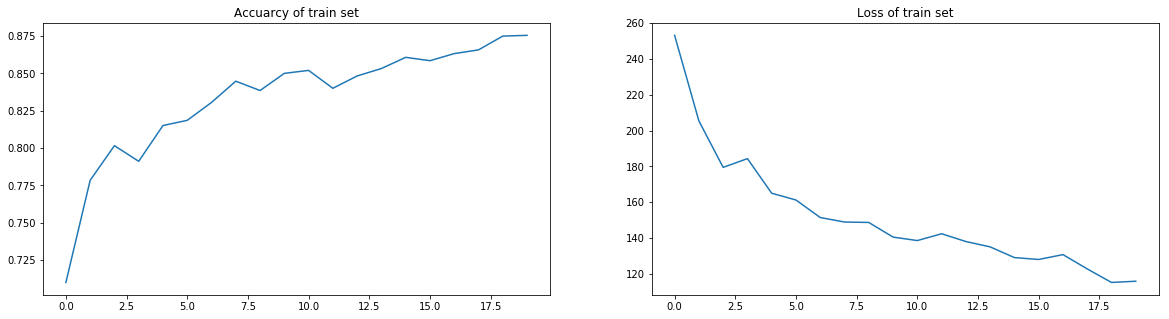

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(train_result['acc'])
plt.title('Accuarcy of train set')
plt.subplot(122)
plt.plot(train_result['loss'])
plt.title('Loss of train set')

In [11]:
test_result_file = './run_results_raw_20/test_20.txt'
test_result = pd.read_csv(test_result_file, ' ') 
print('the best accuracy we get is : ', max(test_result['acc_full']) )
test_result.head(3)

the best accuracy we get is :  0.8984375


,i,acc_0,acc_1,acc_2,acc_other,acc_class,acc_full
0,0,0.805208,0.825980,0.926471,0.789216,0.836719,0.833333
1,1,0.832292,0.720588,0.931373,0.848039,0.833073,0.830729
2,2,0.942708,0.931373,0.857843,0.710784,0.860677,0.855469


Text(0.5, 1.0, 'Average accuracy of all test')

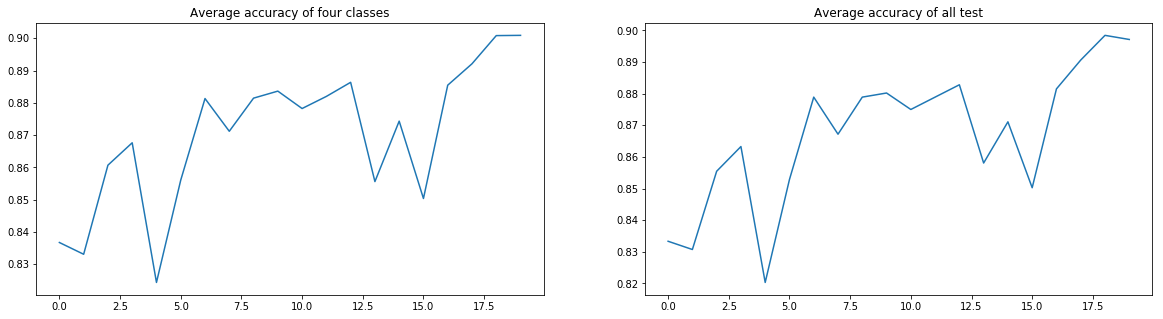

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(121);plt.plot(test_result['acc_class']);plt.title('Average accuracy of four classes')
plt.subplot(122);plt.plot(test_result['acc_full']);plt.title('Average accuracy of all test')

Text(0.5, 1.0, 'Accuracy of Other')

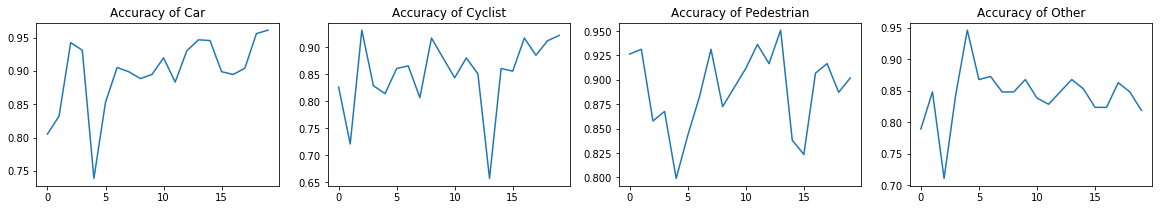

In [15]:
plt.figure(figsize=(20,3))
plt.subplot(141);plt.plot(test_result['acc_0']);plt.title('Accuracy of Car')
plt.subplot(142);plt.plot(test_result['acc_1']);plt.title('Accuracy of Cyclist')
plt.subplot(143);plt.plot(test_result['acc_2']);plt.title('Accuracy of Pedestrian')
plt.subplot(144);plt.plot(test_result['acc_other']);plt.title('Accuracy of Other')

## 1. Choose data set size

* We should not rotate the data, as the data is captured from defined direction, rotate it may destory it.

I prepare to collect 3,000 clouds for each class. (as we see the result from modelnet-40 set, which has less than 1,000 clouds for each class). Considering our task may be a bit harder, as the clouds vary a lot (and we cannot rotate the cloud), I think 3,000 should be enough.

## 2. Augment the data

The class with more data, I will randomly down-sample them.
Then we should augment the class with less than 3,000 clouds, which are the "cyclist", and "pedestrian". 

* We could down-sample the large cloud to create new cloud.
* As we could have occlusion, we could cut part of the cloud to generate new ones.   
  * we could only cut the head from "pedestrian" set, as the head of cyclists are exactly pedestrians, which will introduce uncertainty. 
  * we could cut vertically of the sets. which will be good.

In [ ]:
def augment_data(cloud):
    #TODO

## 3. Make 3D bounding box


In [127]:
from mine_clustering import Kitti_utils
import imp
imp.reload(Kitti_utils)

<module 'mine_clustering.Kitti_utils' from 'D:\\xr\\study\\point cloud\\FinalProject\\mine_clustering\\Kitti_utils.py'>

#### load a test cloud and segment it

In [9]:
folder_ground_truth = 'D:/xr/study/point cloud/Dataset/training/label_2'
folder_point_cloud = 'D:/xr/study/point cloud/Dataset/training/velodyne'
files_ground_truth = glob.glob(folder_ground_truth + '/*.txt')
print("There are ", len(files_ground_truth), " files")

There are  7481  files


In [ ]:
def segmentation_cloud(folder_point_cloud, file_gt, eps = 0.25):
    file_name = file_gt[-10:-4]
    file_velodyne = folder_point_cloud + '/' + file_name + '.bin'

In [141]:
colors = [[0,1,0], [1,1,0], [1,0,1],
          [0,0,1], [0,1,1], [0.5,0.5,0],
          [1,0,0], [0.3,0,0.6], [0.8,0,0.1]]

idx = 458
#idx = random.randint(0,7000)
print(files_ground_truth[idx])
segmented_points, cluster_index, floor_cloud = Kitti_utils.segmentation_cloud(folder_point_cloud, files_ground_truth[idx],0.25)
#mine_seg.plot_clusters_o3d(segmented_points, cluster_index, floor_cloud)

num_filtered = 0
cluster_show = []
for i in range(max(cluster_index)):
    cluster_pts = segmented_points[cluster_index==i]
    ret = Kitti_utils.judge_the_dbscan_cloud(cluster_pts[:,0:3])
    if(ret):
        color = colors[num_filtered%len(colors)]
        num_filtered += 1
        colors_cluster = [color for i in range(cluster_pts.shape[0])]
        point_cloud_o3d = o3d.geometry.PointCloud()
        point_cloud_o3d.points = o3d.utility.Vector3dVector(cluster_pts[:,0:3].reshape(-1,3))
        point_cloud_o3d.colors = o3d.utility.Vector3dVector(colors_cluster)
        cluster_show.append(point_cloud_o3d)
print('result in ', num_filtered, ' clusters.')

point_cloud_floor = o3d.geometry.PointCloud()
point_cloud_floor.points = o3d.utility.Vector3dVector(floor_cloud[:,0:3].reshape(-1,3))
colors_floor = [[0, 0, 0] for i in range(floor_cloud.shape[0])]
point_cloud_floor.colors = o3d.utility.Vector3dVector(colors_floor)

cluster_show.append(point_cloud_floor)
o3d.visualization.draw_geometries(cluster_show)

D:/xr/study/point cloud/Dataset/training/label_2\000458.txt
result in  17  clusters.


#### Check the bounding box results

In [29]:
def get_ground_z(input_cloud):
    distance = np.sqrt(input_cloud[:, 1]*input_cloud[:, 1]+input_cloud[:, 0]*input_cloud[:, 0])
    close_ground = input_cloud[distance < 10]
    return np.mean(close_ground[:,2])
    
def length_in_direction_2d(points_2d, direction):
    projections_on_normal = np.dot(points_2d, direction)
    return max(projections_on_normal)-min(projections_on_normal)
    
def make_bounding_box(cluster_pts, ground_z):
    points_2d = cluster_pts[:,0:2]
    eigenvalues, eigenvectors = Kitti_utils.PCA(points_2d)
    direction_1 = np.transpose(eigenvectors[:, 0])
    length_1 = length_in_direction_2d(points_2d,direction_1)
    length_2 = length_in_direction_2d(points_2d,np.transpose(eigenvectors[:, 1]))
    
    angle = np.arctan2(direction_1[0], direction_1[1])
    #print(length_1, length_2, angle)
    return length_1, length_2, angle

def plot_bounding_box_2d(points_2d, w, l, angle):
    points_vertices = np.array([[l/2, w/2],[l/2,-w/2],[-l/2, w/2], [-l/2, -w/2]])
    rotation_matrix = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    rotated_vertices = np.dot(rotation_matrix, (points_vertices.transpose())).transpose()
    rotated_vertices = rotated_vertices + np.mean(points_2d ,0)

    plt.plot(points_2d[:,0], points_2d[:,1], 'o')
    plt.plot(rotated_vertices[:,0], rotated_vertices[:,1], '*')
    print(rotated_vertices, np.mean(points_2d ,0))

2.008337 0.32102203 -2.987263
[[10.06270284 -3.31838589]
 [10.37141996 -1.33391841]
 [10.37990946 -3.36773269]
 [10.68862658 -1.38326521]] [10.375665  -2.3508255]


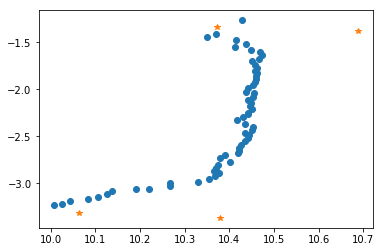

In [14]:
length_1, length_2, angle = make_bounding_box(cluster_pts, -1.6)
plot_bounding_box_2d(cluster_pts[:,0:2],length_1, length_2, angle)

In [132]:
def get_segmentation_and_bounding_box(folder_point_cloud, file_gt):
    segmented_points, cluster_index, floor_cloud = Kitti_utils.segmentation_cloud(folder_point_cloud, file_gt, 0.25)
    num_filtered = 0
    box_sets = []
    if_show = True
    for i in range(max(cluster_index)):
        cluster_pts = segmented_points[cluster_index==i]
        ret = Kitti_utils.judge_the_dbscan_cloud(cluster_pts[:,0:3])
        if(ret and if_show):
            color = colors[num_filtered%len(colors)]
            num_filtered += 1
            colors_cluster = [color for i in range(cluster_pts.shape[0])]
            point_cloud_o3d = o3d.geometry.PointCloud()
            point_cloud_o3d.points = o3d.utility.Vector3dVector(cluster_pts[:,0:3].reshape(-1,3))
            point_cloud_o3d.colors = o3d.utility.Vector3dVector(colors_cluster)
            box_sets.append(point_cloud_o3d)
        if(ret):
            h = 1.6
            length_1, length_2, angle = make_bounding_box(cluster_pts, h)
            center_pt = np.mean(cluster_pts ,0)
            box_set = Kitti_utils.get_3d_box(angle-np.pi/2, -center_pt[1], h, center_pt[0], length_1, h ,length_2)
            box_sets.append(box_set)
            
    print('result in ', num_filtered, ' clusters.')
    point_cloud_floor = o3d.geometry.PointCloud()
    point_cloud_floor.points = o3d.utility.Vector3dVector(floor_cloud[:,0:3].reshape(-1,3))
    colors_floor = [[0, 0, 0] for i in range(floor_cloud.shape[0])]
    point_cloud_floor.colors = o3d.utility.Vector3dVector(colors_floor)
    
    box_sets.append(point_cloud_floor)
    return box_sets

In [133]:
# test
idx = 458
print(files_ground_truth[idx])
show_sets = get_segmentation_and_bounding_box(folder_point_cloud, files_ground_truth[idx])
o3d.visualization.draw_geometries(show_sets)

D:/xr/study/point cloud/Dataset/training/label_2\000458.txt
result in  29  clusters.


Here is the result of a test of bounding box assignment.

![boundingbox_assignment](images/boundingbox_assignment.PNG)

## 4. Run the model and write the results

In [67]:
import torch
import importlib

In [137]:
num_class = 4
labels = ['Car', 'Cyclist', 'Pedestrian']
ROOT_DIR = './'
sys.path.append(os.path.join(ROOT_DIR, 'pointnet2/models'))
model_name = 'pointnet2_cls_msg_ly'
MODEL = importlib.import_module(model_name)
classifier = MODEL.get_model(num_class, True).cuda()

In [138]:
pointnet_model_path = './pointnet2/pointnet2_cls_msg_ly/checkpoints/best_model.pth'
checkpoint = torch.load(pointnet_model_path)
classifier.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [122]:
def pc_normalize(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

def up_sample_points(points, npoint):
    if(points.shape[0] >= npoint):
        return points

    output_points = points
    num_copies = (int)(npoint/points.shape[0]) + 1
    for i in range(num_copies-1):
        output_points = np.concatenate((output_points, points), axis=0)

    return output_points

def random_sample_points(points, npoint):
    indices = np.random.choice(points.shape[0], npoint, replace=False)
    return points[indices]

def classify_cluster(model, cluster, num_class, npoints=256):
    points = pc_normalize(cluster)
    points = up_sample_points(points, npoints)
    points = np.array([points])
    points = torch.from_numpy(points).cuda()
    points = points.transpose(2, 1)
    
    classifier = model.eval()
    pred, _ = classifier(points)
    pred_choice = pred.data.max(1)[1]
    return pred_choice.cpu().numpy()[0]

In [136]:
def segmentation_classify_and_bounding_box(model, num_class, folder_point_cloud, file_gt, output_path):
    segmented_points, cluster_index, floor_cloud = Kitti_utils.segmentation_cloud(folder_point_cloud, file_gt, 0.5)
    output_file = output_path + file_gt[-10:-4] + '.txt'
    f_output = open(output_file, 'w')
    
    num_filtered = 0
    box_sets = []
    for i in range(max(cluster_index)):
        cluster_pts = segmented_points[cluster_index==i]
        ret = Kitti_utils.judge_the_dbscan_cloud(cluster_pts[:,0:3])
        
#         if(ret):
#             color = colors[num_filtered%len(colors)]
#             num_filtered += 1
#             colors_cluster = [color for i in range(cluster_pts.shape[0])]
#             point_cloud_o3d = o3d.geometry.PointCloud()
#             point_cloud_o3d.points = o3d.utility.Vector3dVector(cluster_pts[:,0:3].reshape(-1,3))
#             point_cloud_o3d.colors = o3d.utility.Vector3dVector(colors_cluster)
#             box_sets.append(point_cloud_o3d)
            
        if(ret):
            # classify using point net ++
            result_class = classify_cluster(model, cluster_pts, num_class)
            if(result_class == 3):
                continue
            
            label = labels[result_class]
            #print('label is : ', label)
            
            h = 1.6
            length_1, length_2, angle = make_bounding_box(cluster_pts, h)
            center_pt = np.mean(cluster_pts ,0)

            write_line = label + ' -1 -1 -10 50 50 60 60 ' + str(h) + ' ' + str(length_1) + ' ' + str(length_2) + ' ' + str(-center_pt[1]) + ' ' + str(h) + ' ' + str(center_pt[0]) + ' ' + str(angle-np.pi/2) + '\n'
            f_output.write(write_line)

#             color_y = 0
#             if(result_class == 0):
#                 color_y = 1
#             box_set = Kitti_utils.get_3d_box(angle-np.pi/2, -center_pt[1], 0.0, center_pt[0], length_1, h ,length_2, color_y)
#             box_sets.append(box_set)
            
#     point_cloud_floor = o3d.geometry.PointCloud()
#     point_cloud_floor.points = o3d.utility.Vector3dVector(floor_cloud[:,0:3].reshape(-1,3))
#     colors_floor = [[0, 0, 0] for i in range(floor_cloud.shape[0])]
#     point_cloud_floor.colors = o3d.utility.Vector3dVector(colors_floor)
    
#     box_sets.append(point_cloud_floor)
    
    f_output.close()
    return

In [129]:
# test
# idx = 458
# print(files_ground_truth[idx])
# show_sets = segmentation_classify_and_bounding_box(classifier.eval(), num_class, folder_point_cloud, files_ground_truth[idx])
# o3d.visualization.draw_geometries(show_sets)

D:/xr/study/point cloud/Dataset/training/label_2\000458.txt


In [140]:
pbar = ProgressBar()
output_path = './mine_result/'
for idx in pbar(range(len(files_ground_truth))):
    segmentation_classify_and_bounding_box(classifier.eval(), num_class, folder_point_cloud, files_ground_truth[idx], output_path)

D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:163: RuntimeWarning: invalid value encountered in float_scalars
  thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:176: RuntimeWarning: invalid value encountered in float_scalars
  thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:163: RuntimeWarning: invalid value encountered in float_scalars
  thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:176: RuntimeWarning: invalid value encountered in float_scalars
  thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:163: RuntimeWarning: inv

D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:163: RuntimeWarning: invalid value encountered in float_scalars
  thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:176: RuntimeWarning: invalid value encountered in float_scalars
  thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:163: RuntimeWarning: invalid value encountered in float_scalars
  thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:176: RuntimeWarning: invalid value encountered in float_scalars
  thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
D:\xr\study\point cloud\FinalProject\mine_clustering\Kitti_utils.py:163: RuntimeWarning: inv

### Test result

In [149]:
mine_result_dir = './mine_result'
files_mine_results = glob.glob(mine_result_dir + '/*.txt')
print("There are ", len(files_mine_results), " files")

There are  7481  files


In [151]:
# test
idx = 458
print(files_mine_results[idx])
show_sets, file_velodyne = Kitti_utils.load_ground_true(folder_point_cloud, files_mine_results[idx])

# test show
point_cloud_test = Kitti_utils.load_velo_scan(file_velodyne)
print(" point cloud shape is : ", point_cloud_test.shape)
point_cloud_o3d = o3d.geometry.PointCloud()
point_cloud_o3d.points = o3d.utility.Vector3dVector(point_cloud_test[:,0:3])
show_sets.append(point_cloud_o3d)
o3d.visualization.draw_geometries(show_sets)

./mine_result\000458.txt
 point cloud shape is :  (124899, 4)


![test result](images/test_result.PNG)